In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X, y = data.data, data.target
X.shape, y.shape

((569, 30), (569,))

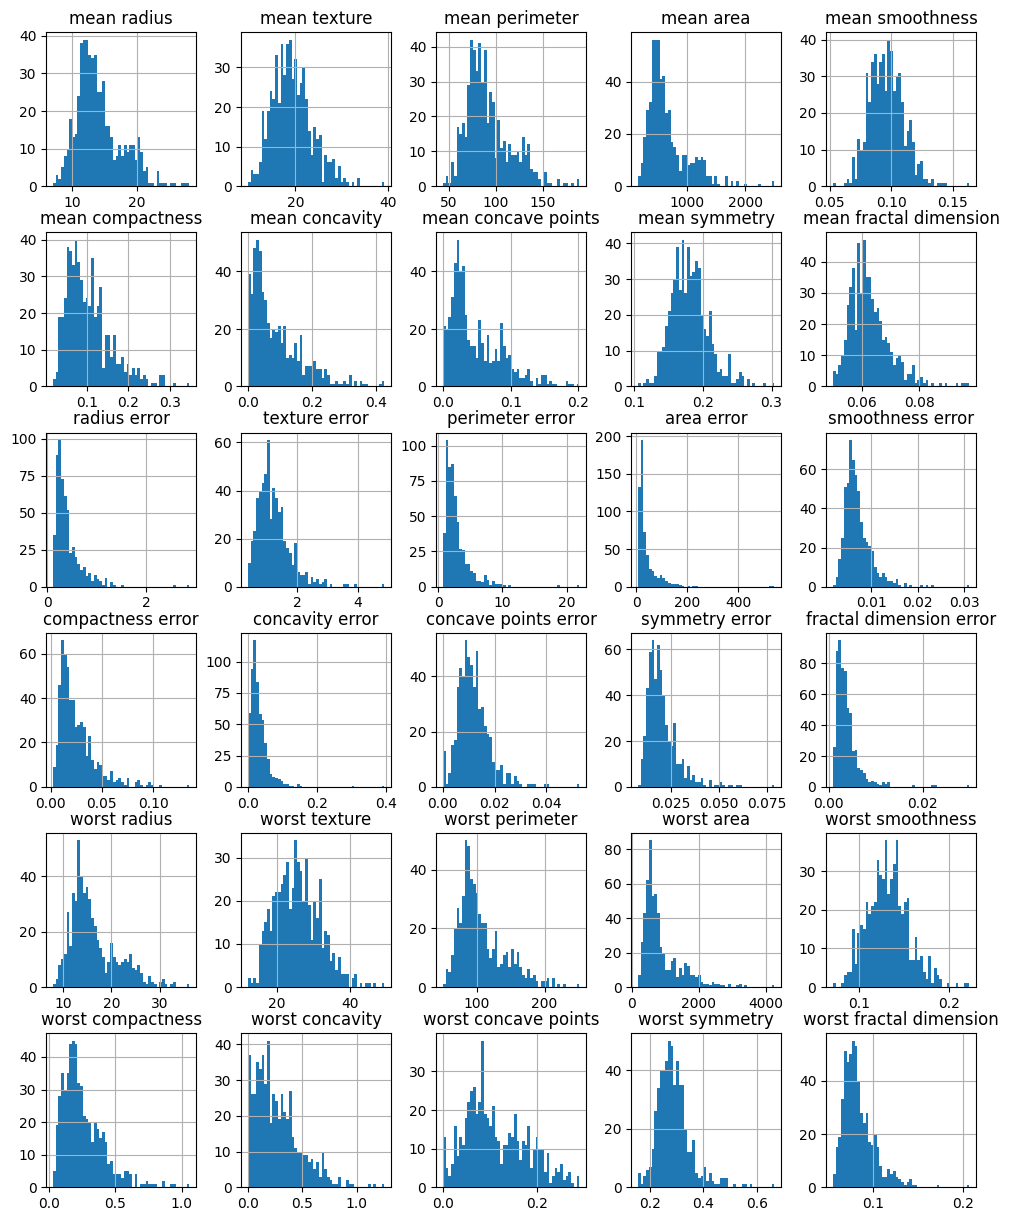

In [3]:
df = pd.DataFrame(X, columns=data.feature_names)
df.hist(figsize=(12, 15), bins=50)
plt.show()

In [4]:
# 학습세트와 예측세트를 분리합니다.
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, random_state=42)

X_train_raw.shape, X_test_raw.shape, y_train_raw.shape, y_test_raw.shape

((426, 30), (143, 30), (426,), (143,))

<img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

In [5]:
# Tensor 변환
X_train = torch.Tensor(X_train_raw)
X_valid = torch.Tensor(X_test_raw)

X_train.shape, X_valid.shape

(torch.Size([426, 30]), torch.Size([143, 30]))

In [6]:
# Label
y_train = torch.Tensor(y_train_raw)
y_valid = torch.Tensor(y_test_raw)
print(y_train.shape, y_valid.shape)
y_train[:5], y_valid[:5]

torch.Size([426]) torch.Size([143])


(tensor([1., 0., 1., 0., 0.]), tensor([1., 0., 0., 1., 1.]))

In [7]:
input_shape = X_train.shape[1]
input_shape

30

## 학습

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.seq(x)
        return x

# 모델 초기화
input_size = X_train.shape[1]
model = LogisticRegression(input_size)

# 손실 함수 및 optimizer 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [9]:
# 모델 초기화
input_size = X_train.shape[1]
model = LogisticRegression(input_size)

# 손실 함수 및 optimizer 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 1000
best_val_loss = 0.0
num_bad_epochs = 0
early_stop_patience = 50
for epoch in range(num_epochs):
    # forward + backward + optimize
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    # 중간 결과 출력
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    # 검증 데이터에 대한 성능 측정
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_valid)
        val_loss = criterion(val_outputs.squeeze(), y_valid)

        # 검증 데이터에 대한 정확도 계산
        val_preds = (val_outputs > 0.5).float()
        val_acc = (val_preds == y_valid).float().mean()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc.item():.4f}')

        # 검증 데이터에 대한 Loss 가 early_stop_patience번 연속 개선되지 않으면 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            num_bad_epochs = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            num_bad_epochs += 1
            if num_bad_epochs == early_stop_patience:
                print("Early stopping")
                break

Epoch [10/1000], Val Loss: 0.5125, Val Acc: 0.5539
Epoch [20/1000], Val Loss: 0.5139, Val Acc: 0.5556
Epoch [30/1000], Val Loss: 0.4928, Val Acc: 0.5385
Epoch [40/1000], Val Loss: 0.4942, Val Acc: 0.5248
Epoch [50/1000], Val Loss: 0.4984, Val Acc: 0.5454
Early stopping


## 예측

## 평가

## Accuracy 